# Movie Recommendation System

## Business Problem

[Letterboxd](https://letterboxd.com/) is a social media platform designed for users to track the movies they've watched, allowing them to quickly access their favorite films and share them with friends.

While the platform emphasizes film sharing and community interaction, it currently lacks a built-in movie recommendation system. Instead, recommendations are driven by the user's social connections and interactions within the platform. This community-based approach, though personal, means users without friends on Letterboxd miss out on receiving new recommendations. 

Introducing a recommendation system that leverages users' viewing and rating history could enhance the platform's value.

## Data Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. 

It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

## Import Packages and Data

In [63]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
# Import data
links_df = pd.read_csv("data/links.csv")
movies_df = pd.read_csv("data/movies.csv")
ratings_df = pd.read_csv("data/ratings.csv")
tags_df = pd.read_csv("data/tags.csv")

In [65]:
# Set a global random seed
np.random.seed(19)

# Exploratory Data Analysis

## Data Investigation

### Column Cleaning

In [3]:
# Define a function to rename the columns
def rename_columns(df):
    df.columns = df.columns.str.replace('([A-Z])', r'_\1', regex=True).str.lower()
    return df

# List of DataFrames
dfs = [links_df, movies_df, ratings_df, tags_df]

# Apply the renaming function to each DataFrame
for df in dfs:
    rename_columns(df)

### Check for Missingness

In [4]:
# Check for missing values
names = ['links_df', 'movies_df', 'ratings_df', 'tags_df']

for name, df in zip(names, dfs):
    print(f"{name} missing values:")
    print(f"Length of DataFrame: {len(df)}")
    print(df.isna().sum())
    print()

links_df missing values:
Length of DataFrame: 9742
movie_id    0
imdb_id     0
tmdb_id     8
dtype: int64

movies_df missing values:
Length of DataFrame: 9742
movie_id    0
title       0
genres      0
dtype: int64

ratings_df missing values:
Length of DataFrame: 100836
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

tags_df missing values:
Length of DataFrame: 3683
user_id      0
movie_id     0
tag          0
timestamp    0
dtype: int64



There is explicit missingness inside of the links_df in the tmdb_id column. However, this is not meaningful and can be ignored. 

The focus of the recommendation systems training will center on the movies_df and the ratings_df. As such, let's see if there is any hidden missingness in either DataFrame. 

#### Movies DataFrame

In [5]:
# Investigate DataFrame
set(movies_df['genres'])

{'(no genres listed)',
 'Action',
 'Action|Adventure',
 'Action|Adventure|Animation',
 'Action|Adventure|Animation|Children',
 'Action|Adventure|Animation|Children|Comedy',
 'Action|Adventure|Animation|Children|Comedy|Fantasy',
 'Action|Adventure|Animation|Children|Comedy|IMAX',
 'Action|Adventure|Animation|Children|Comedy|Romance',
 'Action|Adventure|Animation|Children|Comedy|Sci-Fi',
 'Action|Adventure|Animation|Children|Comedy|Sci-Fi|IMAX',
 'Action|Adventure|Animation|Children|Comedy|Western',
 'Action|Adventure|Animation|Children|Fantasy',
 'Action|Adventure|Animation|Children|Fantasy|Sci-Fi',
 'Action|Adventure|Animation|Children|Sci-Fi',
 'Action|Adventure|Animation|Comedy',
 'Action|Adventure|Animation|Comedy|Crime|Mystery',
 'Action|Adventure|Animation|Comedy|Fantasy|Mystery|Sci-Fi',
 'Action|Adventure|Animation|Comedy|Fantasy|Sci-Fi',
 'Action|Adventure|Animation|Comedy|Sci-Fi',
 'Action|Adventure|Animation|Comedy|Thriller',
 'Action|Adventure|Animation|Crime|Fantasy',
 'Acti

So there are entries that are labeled as '(no genres listed)'. We will want to drop these entries from the dataset.

In [6]:
# Determine data loss from dropping unknown data
no_genres_movies = movies_df[movies_df['genres'] == '(no genres listed)']

print(f"Count of no genre movies: {len(no_genres_movies)}")
print(f"Count of all movies: {len(movies_df)}")
print(f"Percent of movies dropped: {len(no_genres_movies) / len(movies_df)* 100:.2f}%")

Count of no genre movies: 34
Count of all movies: 9742
Percent of movies dropped: 0.35%


In [7]:
# Filter out these movies from the DataFrame
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']

In [8]:
# Show trimmed DataFrame
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9708 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  9708 non-null   int64 
 1   title     9708 non-null   object
 2   genres    9708 non-null   object
dtypes: int64(1), object(2)
memory usage: 303.4+ KB


#### Ratings DataFrame

In [9]:
# Investigate DataFrame
ratings_df['rating'].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

There is no missingness inside of the ratings portion of the ratings DataFrame. 

## DataFrame Metrics

### Movies DataFrame

In [10]:
# Split the genres by '|' and create a binary matrix
genres_expanded = movies_df['genres'].str.get_dummies(sep='|')

In [11]:
# Concatenate the original DataFrame with the new binary genre columns
movies_df_with_genres = pd.concat([movies_df, genres_expanded], axis=1)

In [12]:
# Drop the original 'genres' column if no longer needed
movies_df_with_genres = movies_df_with_genres.drop('genres', axis=1)

In [13]:
# Calculate the frequency of each genre
genre_counts = genres_expanded.sum()

# Sort genres by frequency in descending order
genre_counts_sorted = genre_counts.sort_values(ascending=False)

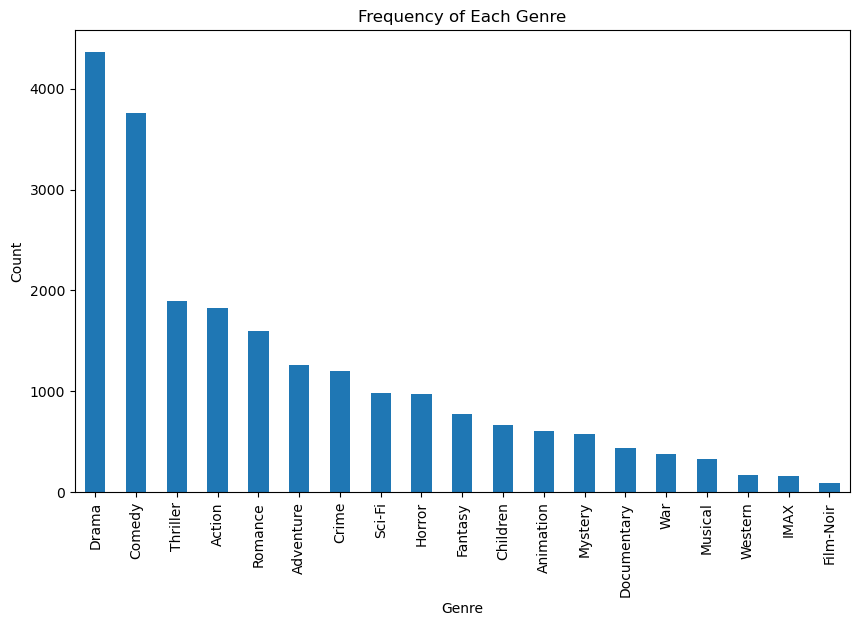

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
genre_counts_sorted.plot(kind='bar')
plt.title('Frequency of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

### Ratings DataFrame

In [15]:
# Calculate the frequency of each rating
ratings_counts = ratings_df['rating'].value_counts()

# Sort genres by frequency in descending order
ratings_counts_sorted = ratings_counts.sort_values(ascending=False)

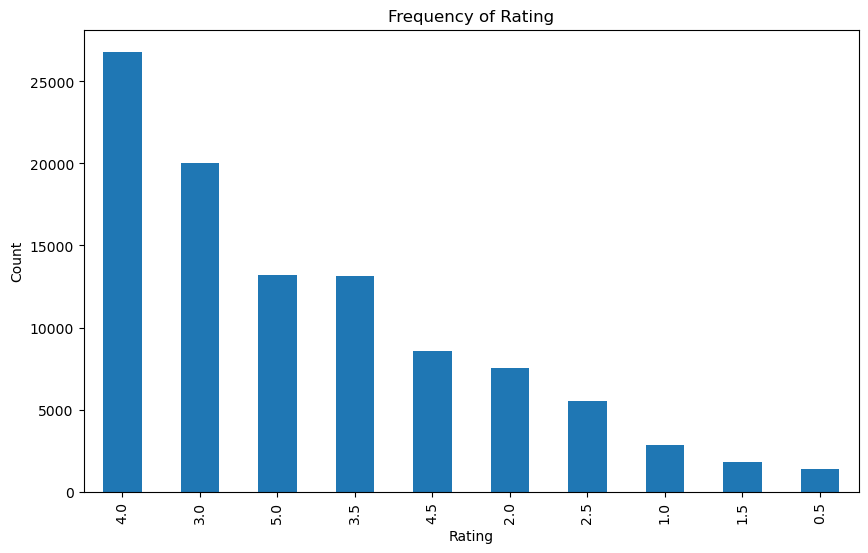

In [16]:
# Plotting
plt.figure(figsize=(10, 6))
ratings_counts_sorted.plot(kind='bar')
plt.title('Frequency of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()